#### Import caffe2_pb2

In [1]:
!nvidia-smi -pm 1
!apt-get update && apt-get install -y tree zip libmagickwand-dev
!pip3 install Wand
from caffe2.proto import caffe2_pb2

Enabled persistence mode for GPU 00000000:00:04.0.
All done.
Ign:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease
Ign:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Get:3 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release [564 B]
Get:4 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release [564 B]
Get:5 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release.gpg [801 B]
Get:6 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release.gpg [801 B]
Get:7 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Packages [98.4 kB]
Get:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Packages [16.8 kB]
Get:9 http://security.ubuntu.com/ubuntu xenial-security InRelease [102 kB]     
Get:10 http://archive.ubuntu.com/

Get:39 http://archive.ubuntu.com/ubuntu xenial/main amd64 libxt-dev amd64 1:1.1.5-0ubuntu1 [394 kB]
Get:40 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libmagickcore-6.q16-dev amd64 8:6.8.9.9-7ubuntu5.9 [918 kB]
Get:41 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libmagickwand-6-headers all 8:6.8.9.9-7ubuntu5.9 [20.1 kB]
Get:42 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libmagickwand-6.q16-dev amd64 8:6.8.9.9-7ubuntu5.9 [278 kB]
Get:43 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libmagickwand-dev all 8:6.8.9.9-7ubuntu5.9 [11.4 kB]
Get:44 http://archive.ubuntu.com/ubuntu xenial/universe amd64 tree amd64 1.7.0-3 [40.6 kB]
Get:45 http://archive.ubuntu.com/ubuntu xenial/main amd64 zip amd64 3.0-11 [158 kB]
Fetched 19.1 MB in 2s (7308 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package imagemagick-common.
(Reading database ... 56404 files and directories currently i

Selecting previously unselected package libmagickwand-dev.
Preparing to unpack .../libmagickwand-dev_8%3a6.8.9.9-7ubuntu5.9_all.deb ...
Unpacking libmagickwand-dev (8:6.8.9.9-7ubuntu5.9) ...
Selecting previously unselected package tree.
Preparing to unpack .../tree_1.7.0-3_amd64.deb ...
Unpacking tree (1.7.0-3) ...
Selecting previously unselected package zip.
Preparing to unpack .../archives/zip_3.0-11_amd64.deb ...
Unpacking zip (3.0-11) ...
Processing triggers for libc-bin (2.23-0ubuntu10) ...
Processing triggers for fontconfig (2.11.94-0ubuntu1.1) ...
Processing triggers for libgdk-pixbuf2.0-0:amd64 (2.32.2-1ubuntu1.4) ...
Setting up imagemagick-common (8:6.8.9.9-7ubuntu5.9) ...
Setting up libexif12:amd64 (0.6.21-2) ...
Setting up libfftw3-double3:amd64 (3.3.4-2ubuntu1) ...
Setting up liblqr-1-0:amd64 (0.4.2-2) ...
Setting up libmagickcore-6-arch-config:amd64 (8:6.8.9.9-7ubuntu5.9) ...
Setting up libmagickcore-6-headers (8:6.8.9.9-7ubuntu5.9) ...
Setting up libmagickcore-6.q16-2:amd

#### Same code as CPU

In [2]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import caffe2.python.predictor.predictor_exporter as pe


from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, a more complicated convolutional model is used
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile
    from io import BytesIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(BytesIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
    
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

def AddInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

def AddMLPModel(model, data):
    size = 28 * 28 * 1
    sizes = [size, size * 2, size * 2, 10]
    layer = data
    for i in range(len(sizes) - 1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i + 1])
        layer = model.net.Relu(layer, 'relu_{}'.format(i))
    softmax = model.net.Softmax(layer, 'softmax')
    return softmax

def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = model.net.MaxPool(conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = model.net.MaxPool(conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = model.net.Relu(fc3, 'relu3')
    pred = brew.fc(model, fc3, 'pred', 500, 10)
    softmax = model.net.Softmax(pred, 'softmax')
    return softmax

def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)
    
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = model.Accuracy([softmax, label], "accuracy")
    return accuracy

def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
    
    
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

Necessities imported!
Your data folder was not found!! This was generated: /root/caffe2_notebooks/tutorial_data/mnist
one or both of the MNIST lmbd dbs not found!!
Downloading... http://download.caffe2.ai/databases/mnist-lmdb.zip to /root/caffe2_notebooks/tutorial_data/mnist
Completed download and extraction.
training data folder:/root/caffe2_notebooks/tutorial_data/mnist
workspace root folder:/root/caffe2_notebooks/tutorial_files/tutorial_mnist


#### Instantiate model under `DeviceScope`

Caffe2 has the concepts of `scopes`, which means that you can set global values of some key-value pairs for whatever operator that is under the scope. With `DeviceScope`, we are setting all the operators underneath this scope to run on GPU. With `arg_scope`, we are setting some global values in a model. Hence, using scopes, you can achieve some dynamic execution of your model, i.e. you can run some operators in CPU and some in GPU, provide a group of operators to have the same key-value pairs, etc.

Loss: 2.4174611568450928, Accuracy: 0.078125
Loss: 2.186471939086914, Accuracy: 0.1875
Loss: 2.247565507888794, Accuracy: 0.1875
Loss: 1.9989920854568481, Accuracy: 0.375
Loss: 1.8867642879486084, Accuracy: 0.546875
Loss: 1.6805620193481445, Accuracy: 0.6875
Loss: 1.6112921237945557, Accuracy: 0.625
Loss: 1.5184285640716553, Accuracy: 0.59375
Loss: 1.3884860277175903, Accuracy: 0.609375
Loss: 1.5202124118804932, Accuracy: 0.5
Loss: 1.4763392210006714, Accuracy: 0.515625
Loss: 1.9597958326339722, Accuracy: 0.484375
Loss: 1.3814588785171509, Accuracy: 0.515625
Loss: 1.2565362453460693, Accuracy: 0.609375
Loss: 1.1322765350341797, Accuracy: 0.671875
Loss: 0.9353267550468445, Accuracy: 0.765625
Loss: 1.0536673069000244, Accuracy: 0.734375
Loss: 1.077551007270813, Accuracy: 0.671875
Loss: 0.6285427808761597, Accuracy: 0.859375
Loss: 0.7551718950271606, Accuracy: 0.78125
Loss: 0.7012122869491577, Accuracy: 0.8125
Loss: 1.1544859409332275, Accuracy: 0.609375
Loss: 0.9899256229400635, Accuracy

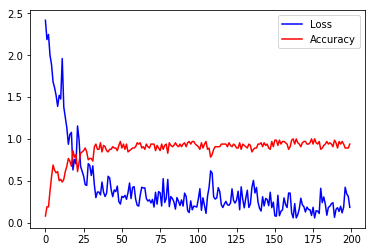

In [3]:

device_opt = core.DeviceOption(caffe2_pb2.CUDA, 0) # Notice we have put index as 0.
# Picking that one GPU
with core.DeviceScope(device_opt):
    # Everything else under is the same as the CPU code
    arg_scope = {"order": "NCHW", "use_cudnn":True}
    train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
    data, label = AddInput(
        train_model, batch_size=64,
        db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
        db_type='lmdb')
    softmax = AddModel(train_model, data)
    AddTrainingOperators(train_model, softmax, label)
    AddBookkeepingOperators(train_model)

# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are going to be initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
# We need this as its going to be used a lot.
# So we avoid an object every single time it is used.
 
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    print("Loss: {}, Accuracy: {}".format(loss[i], accuracy[i]))

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

### 2. Caffe2 - Detectron

Detectron is Facebook AI Research's software system that implements state-of-the-art object detection algorithms, including Fast R-CNN, Faster R-CNN, Mask R-CNN, RetinaNet etc.

In [4]:
!tree -d /detectron

/detectron
|-- cocoapi
|   |-- LuaAPI
|   |   `-- rocks
|   |-- MatlabAPI
|   |   `-- private
|   |-- PythonAPI
|   |   `-- pycocotools
|   |-- common
|   `-- results
|-- configs
|   |-- 12_2017_baselines
|   |-- getting_started
|   `-- test_time_aug
|-- demo
|   `-- output
|-- docker
|-- lib
|   |-- Detectron.egg-info
|   |-- build
|   |   |-- CMakeFiles
|   |   |   |-- 3.5.1
|   |   |   |   |-- CompilerIdC
|   |   |   |   `-- CompilerIdCXX
|   |   |   |-- CMakeTmp
|   |   |   |-- caffe2_detectron_custom_ops.dir
|   |   |   |   `-- ops
|   |   |   `-- caffe2_detectron_custom_ops_gpu.dir
|   |   |       `-- ops
|   |   |-- lib.linux-x86_64-3.5
|   |   |   `-- utils
|   |   `-- temp.linux-x86_64-3.5
|   |       `-- utils
|   |-- cmake
|   |   `-- Modules
|   |-- core
|   |   `-- __pycache__
|   |-- datasets
|   |   |-- VOCdevkit-matlab-wrapper
|   |   |-- __pycache__
|   |   |-- cityscapes
|   |   |   `-- tools
|   |   `-- data
|   |-- modeling
|   |   `-- __pycache__
|   |-- ops
|   | 

####  Running Faster-RCNN model inference

In [5]:
%%writefile /detectron/configs/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml
MODEL:
  TYPE: generalized_rcnn
  CONV_BODY: ResNet.add_ResNet50_conv4_body
  NUM_CLASSES: 81
  FASTER_RCNN: True
NUM_GPUS: 8
SOLVER:
  WEIGHT_DECAY: 0.0001
  LR_POLICY: steps_with_decay
  BASE_LR: 0.01
  GAMMA: 0.1
  # 1x schedule (note TRAIN.IMS_PER_BATCH: 1)
  MAX_ITER: 180000
  STEPS: [0, 120000, 160000]
RPN:
  SIZES: (32, 64, 128, 256, 512)
FAST_RCNN:
  ROI_BOX_HEAD: ResNet.add_ResNet_roi_conv5_head
  ROI_XFORM_METHOD: RoIAlign
TRAIN:
  WEIGHTS: https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-50.pkl
  DATASETS: ('coco_2014_train', 'coco_2014_valminusminival')
  SCALES: (800,)
  MAX_SIZE: 1333
  IMS_PER_BATCH: 1
  BATCH_SIZE_PER_IM: 512
TEST:
  DATASETS: ('coco_2014_minival',)
  SCALES: (800,)
  MAX_SIZE: 1333
  NMS: 0.5
  RPN_PRE_NMS_TOP_N: 6000
  RPN_POST_NMS_TOP_N: 1000
OUTPUT_DIR: .


Overwriting /detectron/configs/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml


ROI_XFORM_Method stands for RoI transformation function. it has roi based method such as  RoIPool and RoIAlign.
- RoIPool: ROI pooling method to allow only one forward/backward pass for multiple ROIs in one input image.
- RoIAlign: For ROIAlign, in each ROI bin, the value of the four regularly sampled locations are computed directly through bilinear interpolation.


- Non-maximum Suppression : Non‐max suppression discards objects with low detection probability and it selects object with maximum probability, then discard all boxes IoU> 0.5 with selected boxes <br>
- RPN_POST_NMS_TOP_N is Number of top scoring boxes to keep before apply NMS to RPN proposals <br>
- RPN_POST_NMS_TOP_N is  Number of top scoring boxes to keep after apply NMS to RPN proposals <br>


In [6]:
%cd /detectron/
!python3 tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml \
    --output-dir /workspace/faster-rcnn-visualization-1 \
    --image-ext jpg \
    --wts https://s3-us-west-2.amazonaws.com/detectron/35857197/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml.01_33_49.iAX0mXvW/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl \
        demo/15673749081_767a7fa63a_k.jpg

/detectron
E0306 22:28:42.574437   941 init_intrinsics_check.cc:59] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:28:42.574473   941 init_intrinsics_check.cc:59] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:28:42.574481   941 init_intrinsics_check.cc:59] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
INFO io.py:  68: Downloading remote file https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-50.pkl to /tmp/detectron-download-cache/ImageNetPretrained/MSRA/R-50.pkl
  [============================================================] 100.0% of 97.6MB file  
INFO io.py:  68: Downloading remote file https://s3-us-west-2.amazonaws.com/detectron/35857197/12_2017_baseline

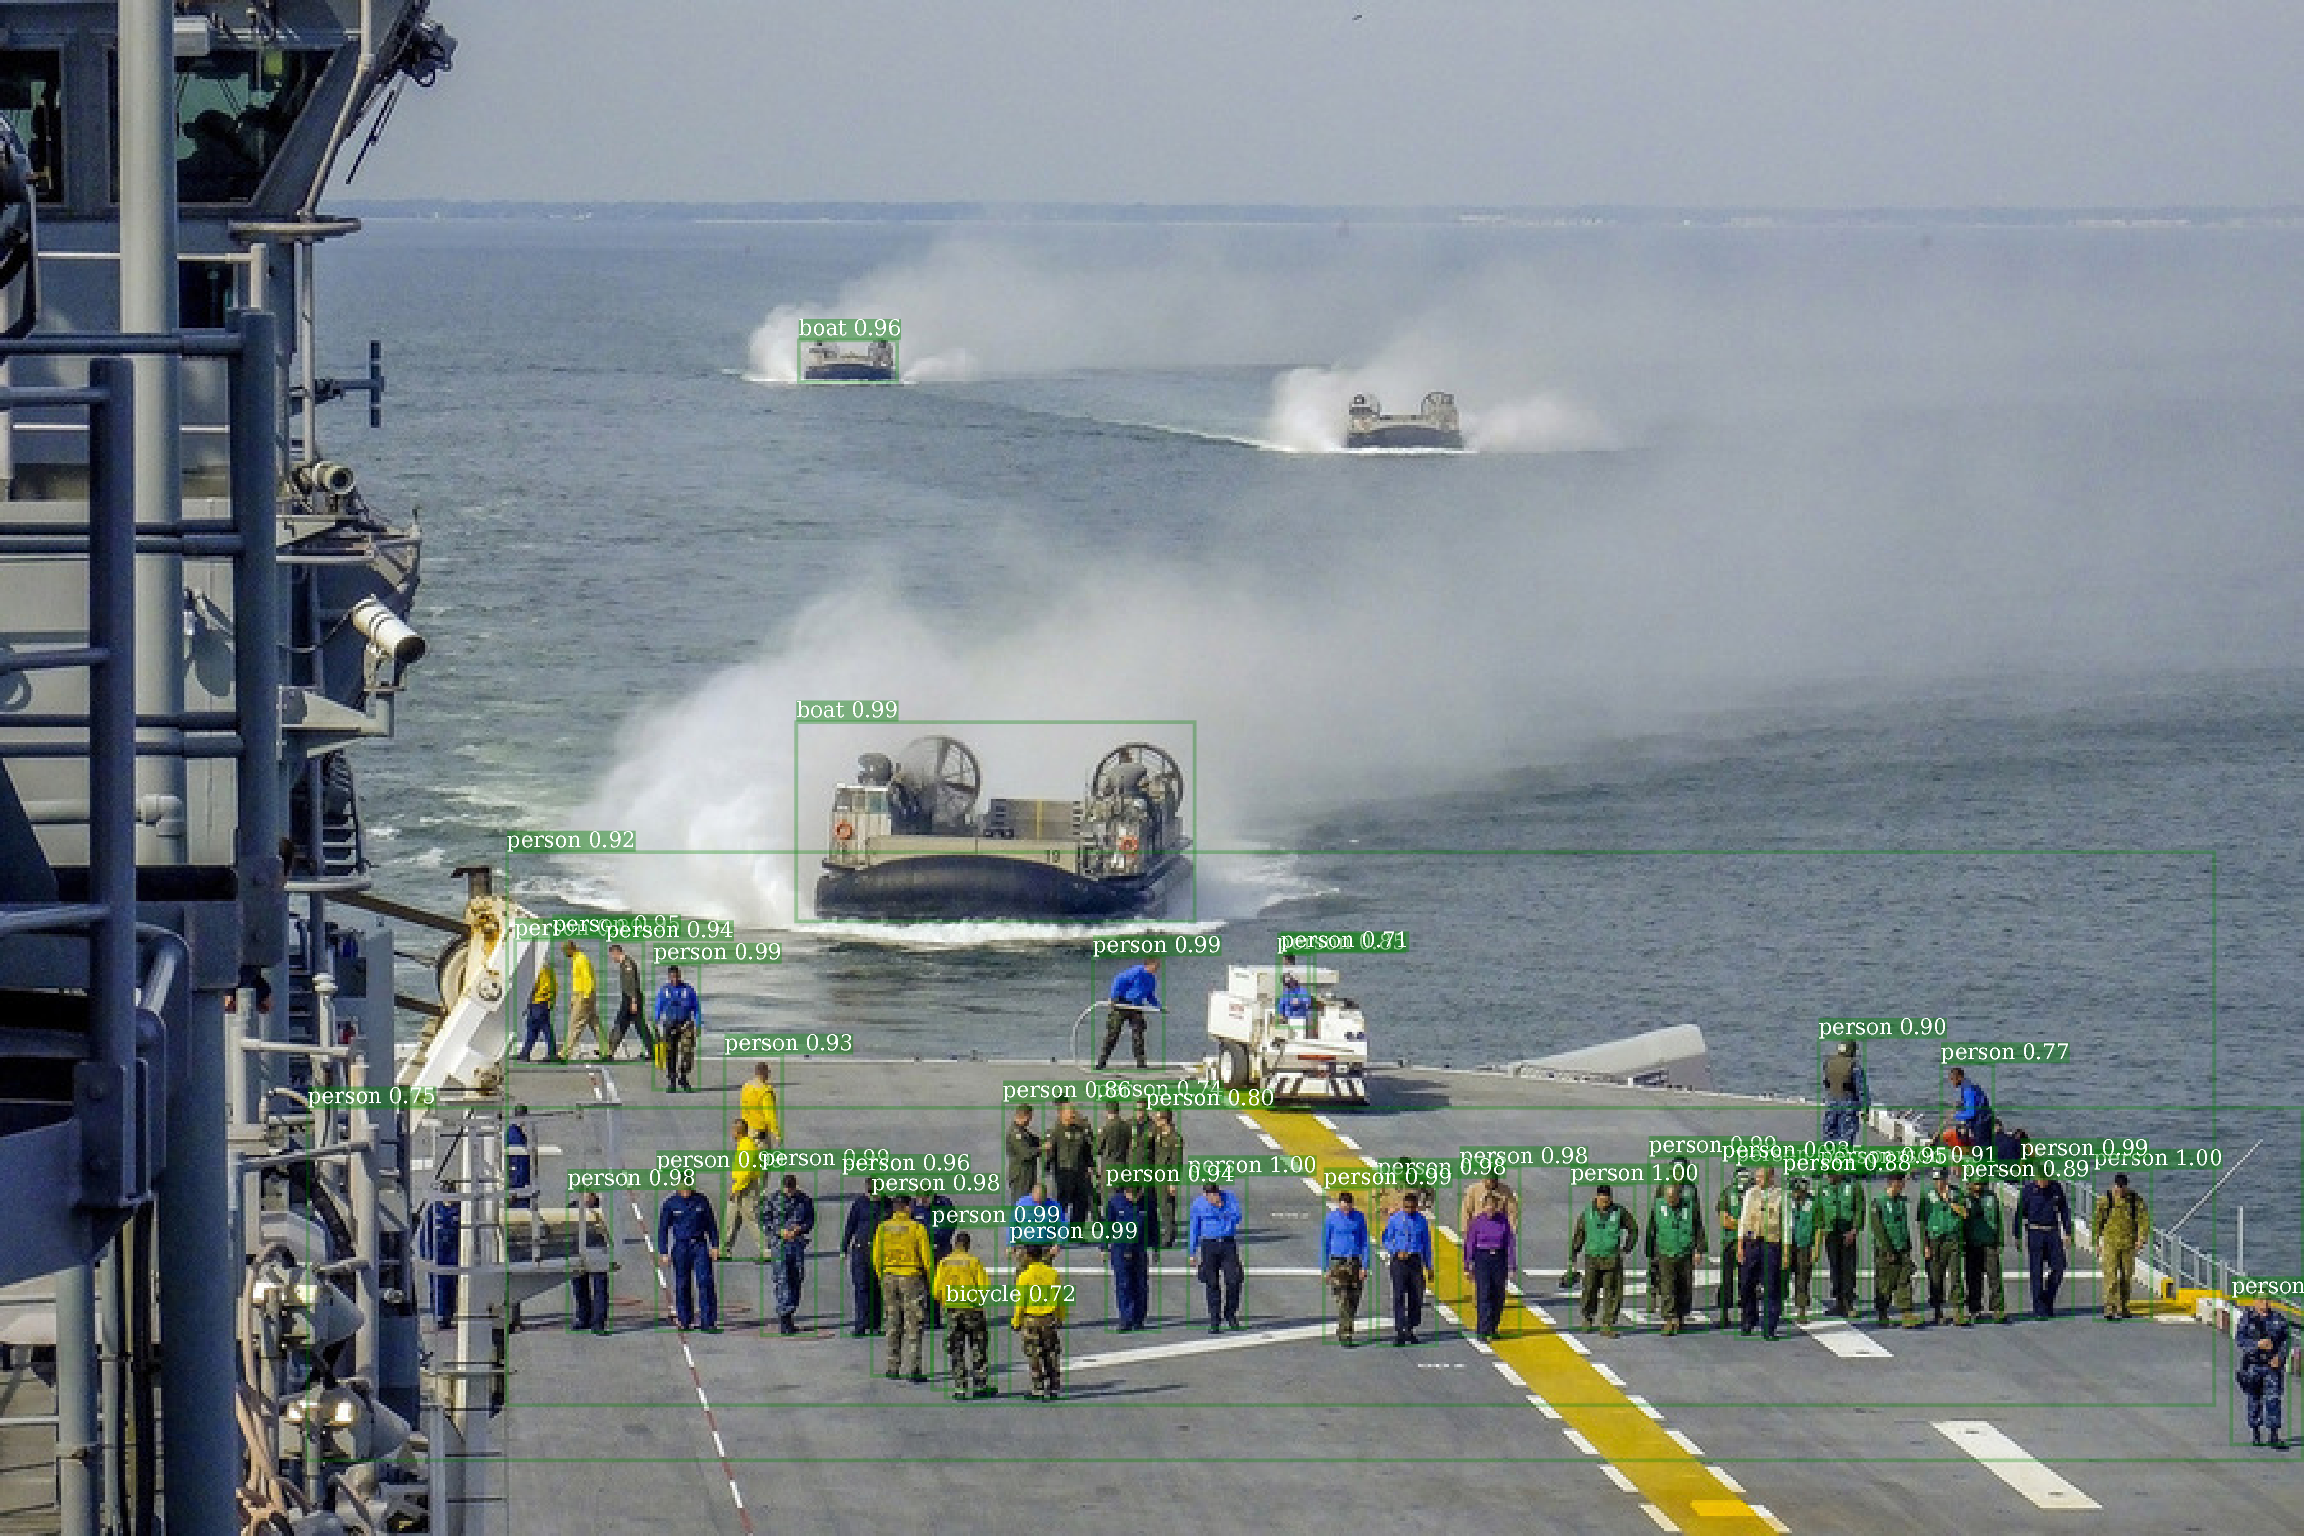

In [7]:
from wand.image import Image as WImage
WImage(filename='/workspace/faster-rcnn-visualization-1/15673749081_767a7fa63a_k.jpg.pdf', resolution=512)

 inference time 2.067s

In [8]:
%%writefile /detectron/configs/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml
MODEL:
  TYPE: generalized_rcnn
  CONV_BODY: ResNet.add_ResNet50_conv4_body
  NUM_CLASSES: 81
  FASTER_RCNN: True
NUM_GPUS: 8
SOLVER:
  WEIGHT_DECAY: 0.0001
  LR_POLICY: steps_with_decay
  BASE_LR: 0.01
  GAMMA: 0.1
  # 1x schedule (note TRAIN.IMS_PER_BATCH: 1)
  MAX_ITER: 180000
  STEPS: [0, 120000, 160000]
RPN:
  SIZES: (32, 64, 128, 256, 512)
FAST_RCNN:
  ROI_BOX_HEAD: ResNet.add_ResNet_roi_conv5_head
  ROI_XFORM_METHOD: RoIAlign
TRAIN:
  WEIGHTS: https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-50.pkl
  DATASETS: ('coco_2014_train', 'coco_2014_valminusminival')
  SCALES: (800,)
  MAX_SIZE: 1333
  IMS_PER_BATCH: 1
  BATCH_SIZE_PER_IM: 512
TEST:
  DATASETS: ('coco_2014_minival',)
  SCALES: (800,)
  MAX_SIZE: 1333
  NMS: 0.5
  RPN_PRE_NMS_TOP_N: 20
  RPN_POST_NMS_TOP_N: 10
OUTPUT_DIR: .

Overwriting /detectron/configs/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml


In [9]:
%cd /detectron/
!python3 tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml \
    --output-dir /workspace/faster-rcnn-visualization-2 \
    --image-ext jpg \
    --wts https://s3-us-west-2.amazonaws.com/detectron/35857197/12_2017_baselines/e2e_faster_rcnn_R-50-C4_1x.yaml.01_33_49.iAX0mXvW/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl \
        demo/15673749081_767a7fa63a_k.jpg

/detectron
E0306 22:30:23.807437   985 init_intrinsics_check.cc:59] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:30:23.807471   985 init_intrinsics_check.cc:59] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:30:23.807477   985 init_intrinsics_check.cc:59] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
WARNING cnn.py:  40: [====DEPRECATE WARNING====]: you are creating an object from CNNModelHelper class which will be deprecated soon. Please use ModelHelper object with brew module. For more information, please refer to caffe2.ai and python/brew.py, python/brew_test.py for more information.
INFO net.py:  57: Loading weights from: /tmp/detectron-download-cache/35857197/12_2017_baseli

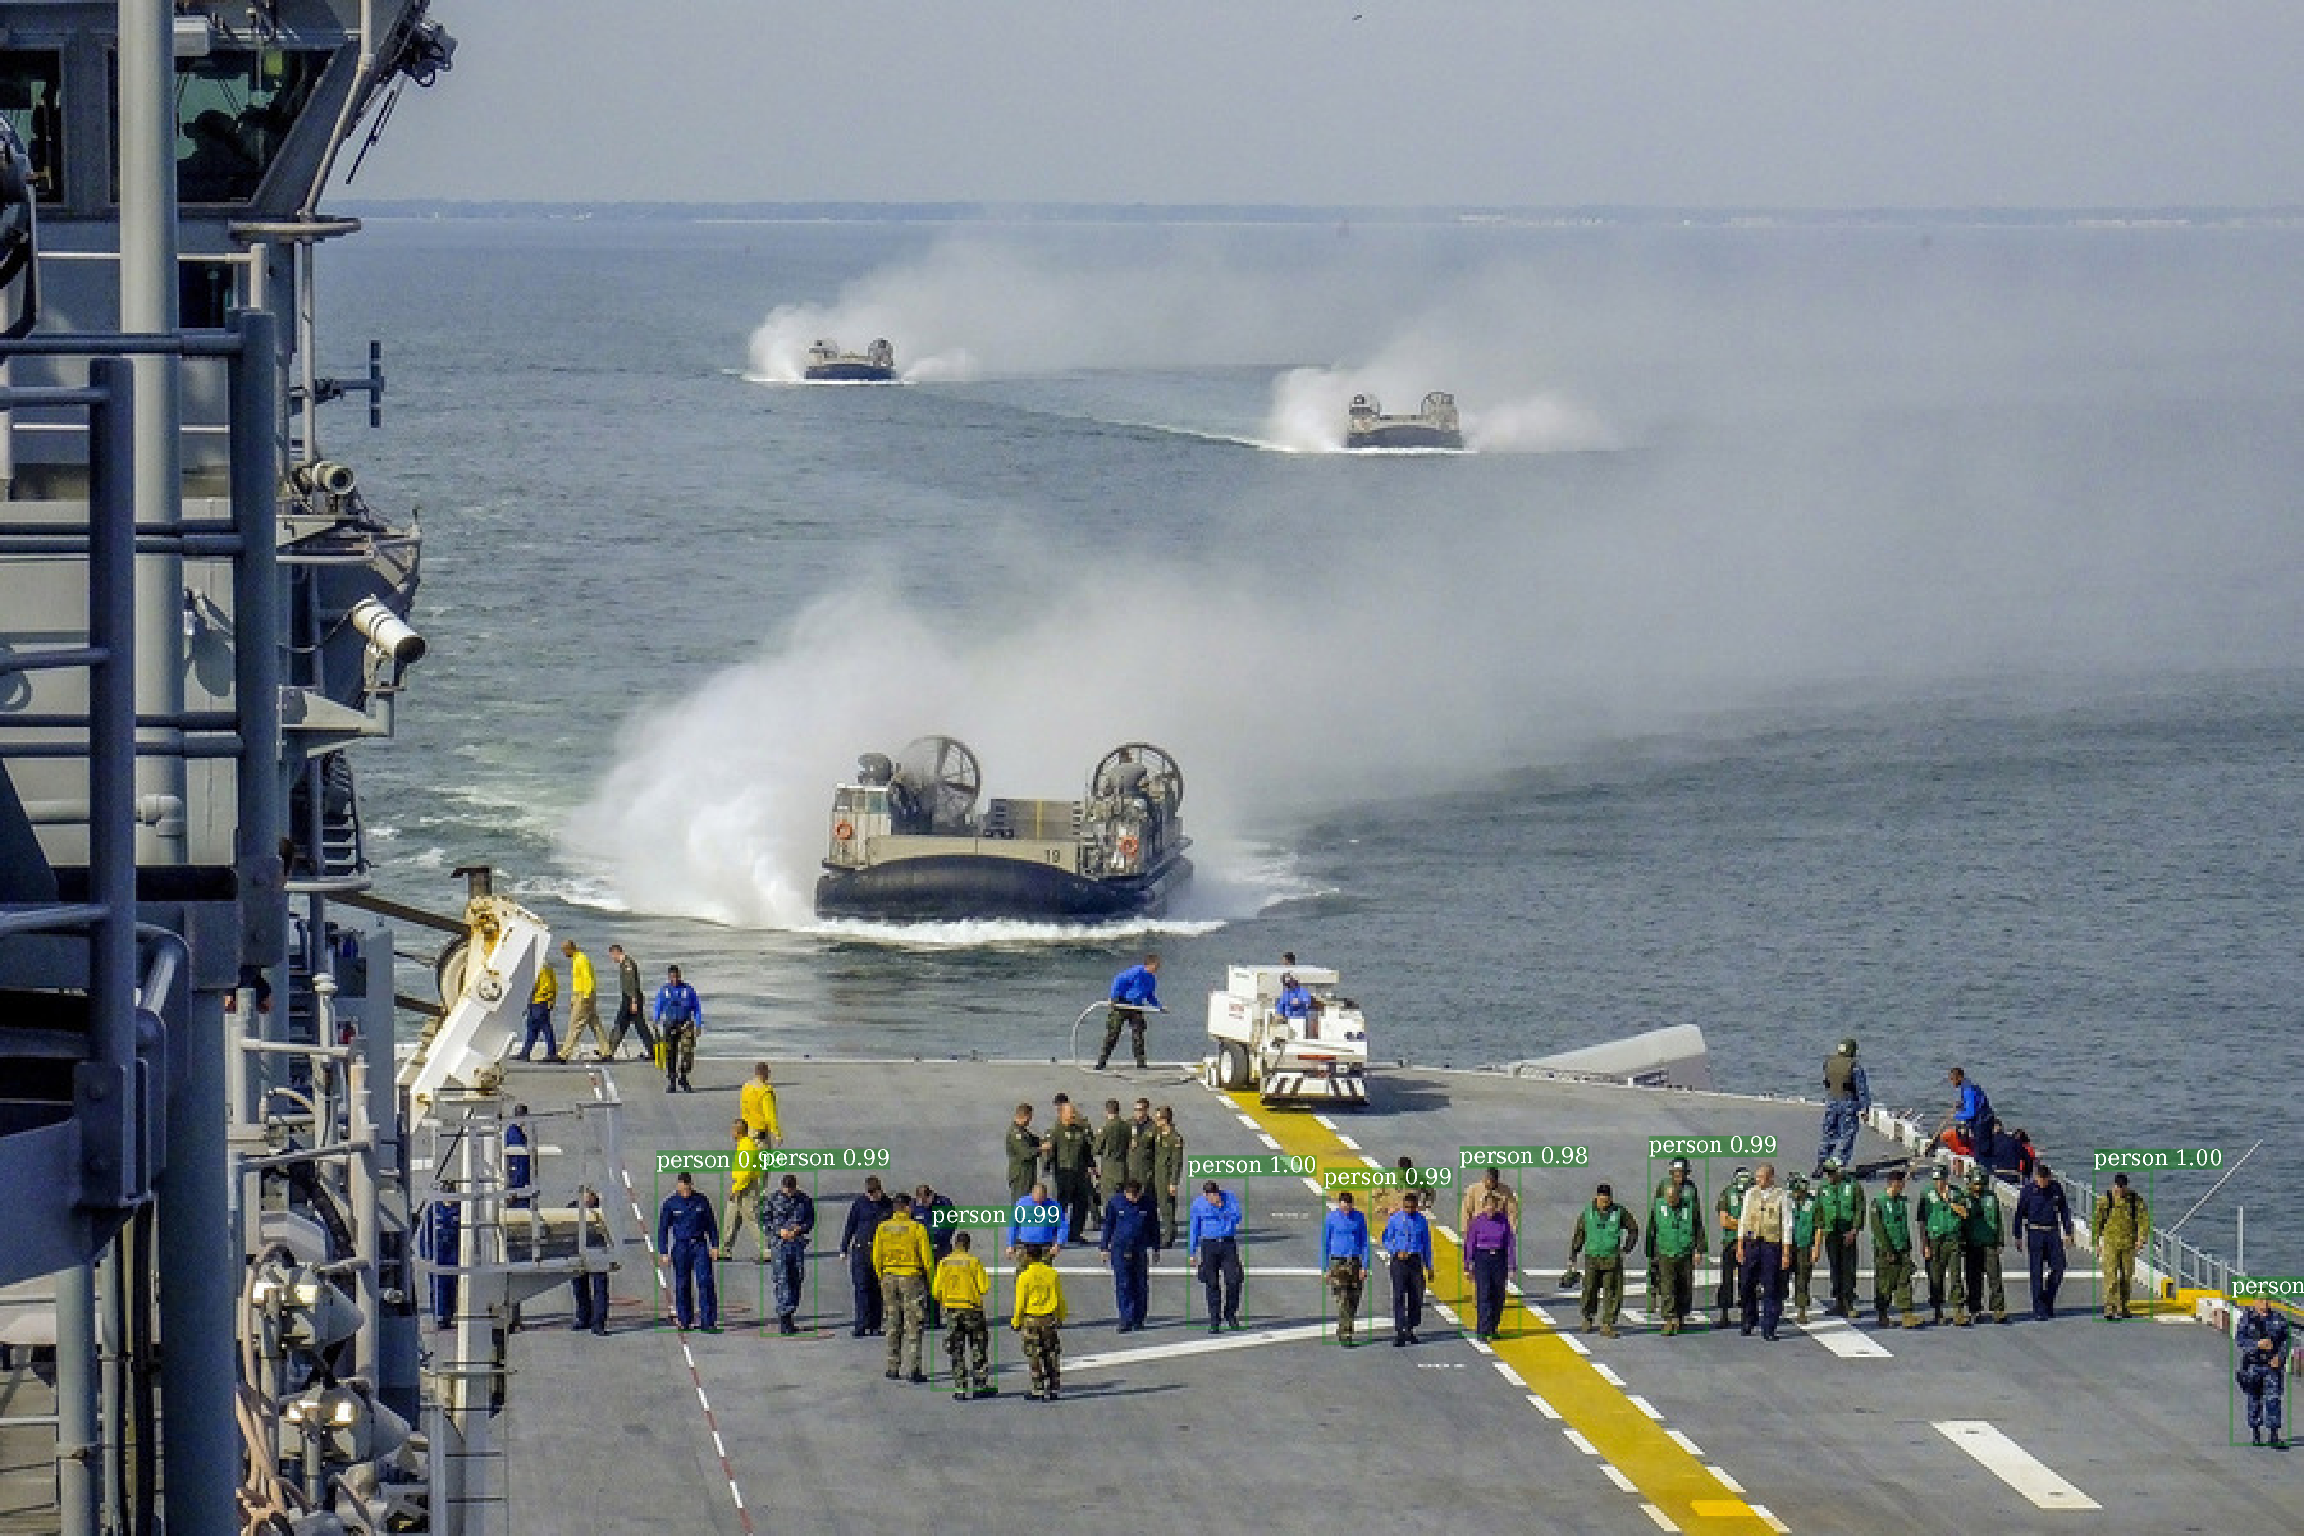

In [10]:
from wand.image import Image as WImage
WImage(filename='/workspace/faster-rcnn-visualization-2/15673749081_767a7fa63a_k.jpg.pdf', resolution=512)

**Inference time with lower `RPN_PRE_NMS_TOP_N` and `RPN_POST_NMS_TOP_N`**: 0.876s

 lower RPN_PRE_NMS_TOP_N and RPN_POST_NMS_TOP_N will reduces number of proposal for classifier. It improves quality of result but also reduces number of objects detected

##### Running a Faster-RCNN model with Resnet-50 and Feature Pyramid Network (FPN) with `RPN_PRE_NMS_TOP_N: 6000`  and `RPN_POST_NMS_TOP_N: 1000`

In [11]:
%%writefile configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml
MODEL:
  TYPE: generalized_rcnn
  CONV_BODY: FPN.add_fpn_ResNet101_conv5_body
  NUM_CLASSES: 81
  FASTER_RCNN: True
NUM_GPUS: 8
SOLVER:
  WEIGHT_DECAY: 0.0001
  LR_POLICY: steps_with_decay
  BASE_LR: 0.02
  GAMMA: 0.1
  MAX_ITER: 90000
  STEPS: [0, 60000, 80000]
FPN:
  FPN_ON: True
  MULTILEVEL_ROIS: True
  MULTILEVEL_RPN: True
FAST_RCNN:
  ROI_BOX_HEAD: fast_rcnn_heads.add_roi_2mlp_head
  ROI_XFORM_METHOD: RoIAlign
  ROI_XFORM_RESOLUTION: 7
  ROI_XFORM_SAMPLING_RATIO: 2
TRAIN:
  WEIGHTS: https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-101.pkl
  DATASETS: ('coco_2014_train', 'coco_2014_valminusminival')
  SCALES: (800,)
  MAX_SIZE: 1333
  BATCH_SIZE_PER_IM: 512
  RPN_PRE_NMS_TOP_N: 2000  # Per FPN level
TEST:
  DATASETS: ('coco_2014_minival',)
  SCALES: (800,)
  MAX_SIZE: 1333
  NMS: 0.5
  RPN_PRE_NMS_TOP_N: 6000  # Per FPN level
  RPN_POST_NMS_TOP_N: 1000
OUTPUT_DIR: .


Overwriting configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml


In [12]:
%cd /detectron/
!python3 tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml \
    --output-dir /workspace/faster-rcnn-visualization-3 \
    --image-ext jpg \
    --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml.01_38_50.sNxI7sX7/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl \
        demo/15673749081_767a7fa63a_k.jpg

/detectron
E0306 22:30:50.129792  1010 init_intrinsics_check.cc:59] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:30:50.129827  1010 init_intrinsics_check.cc:59] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:30:50.129833  1010 init_intrinsics_check.cc:59] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
INFO io.py:  68: Downloading remote file https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-101.pkl to /tmp/detectron-download-cache/ImageNetPretrained/MSRA/R-101.pkl
  [============================================================] 100.0% of 170.2MB file  
INFO io.py:  68: Downloading remote file https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_basel

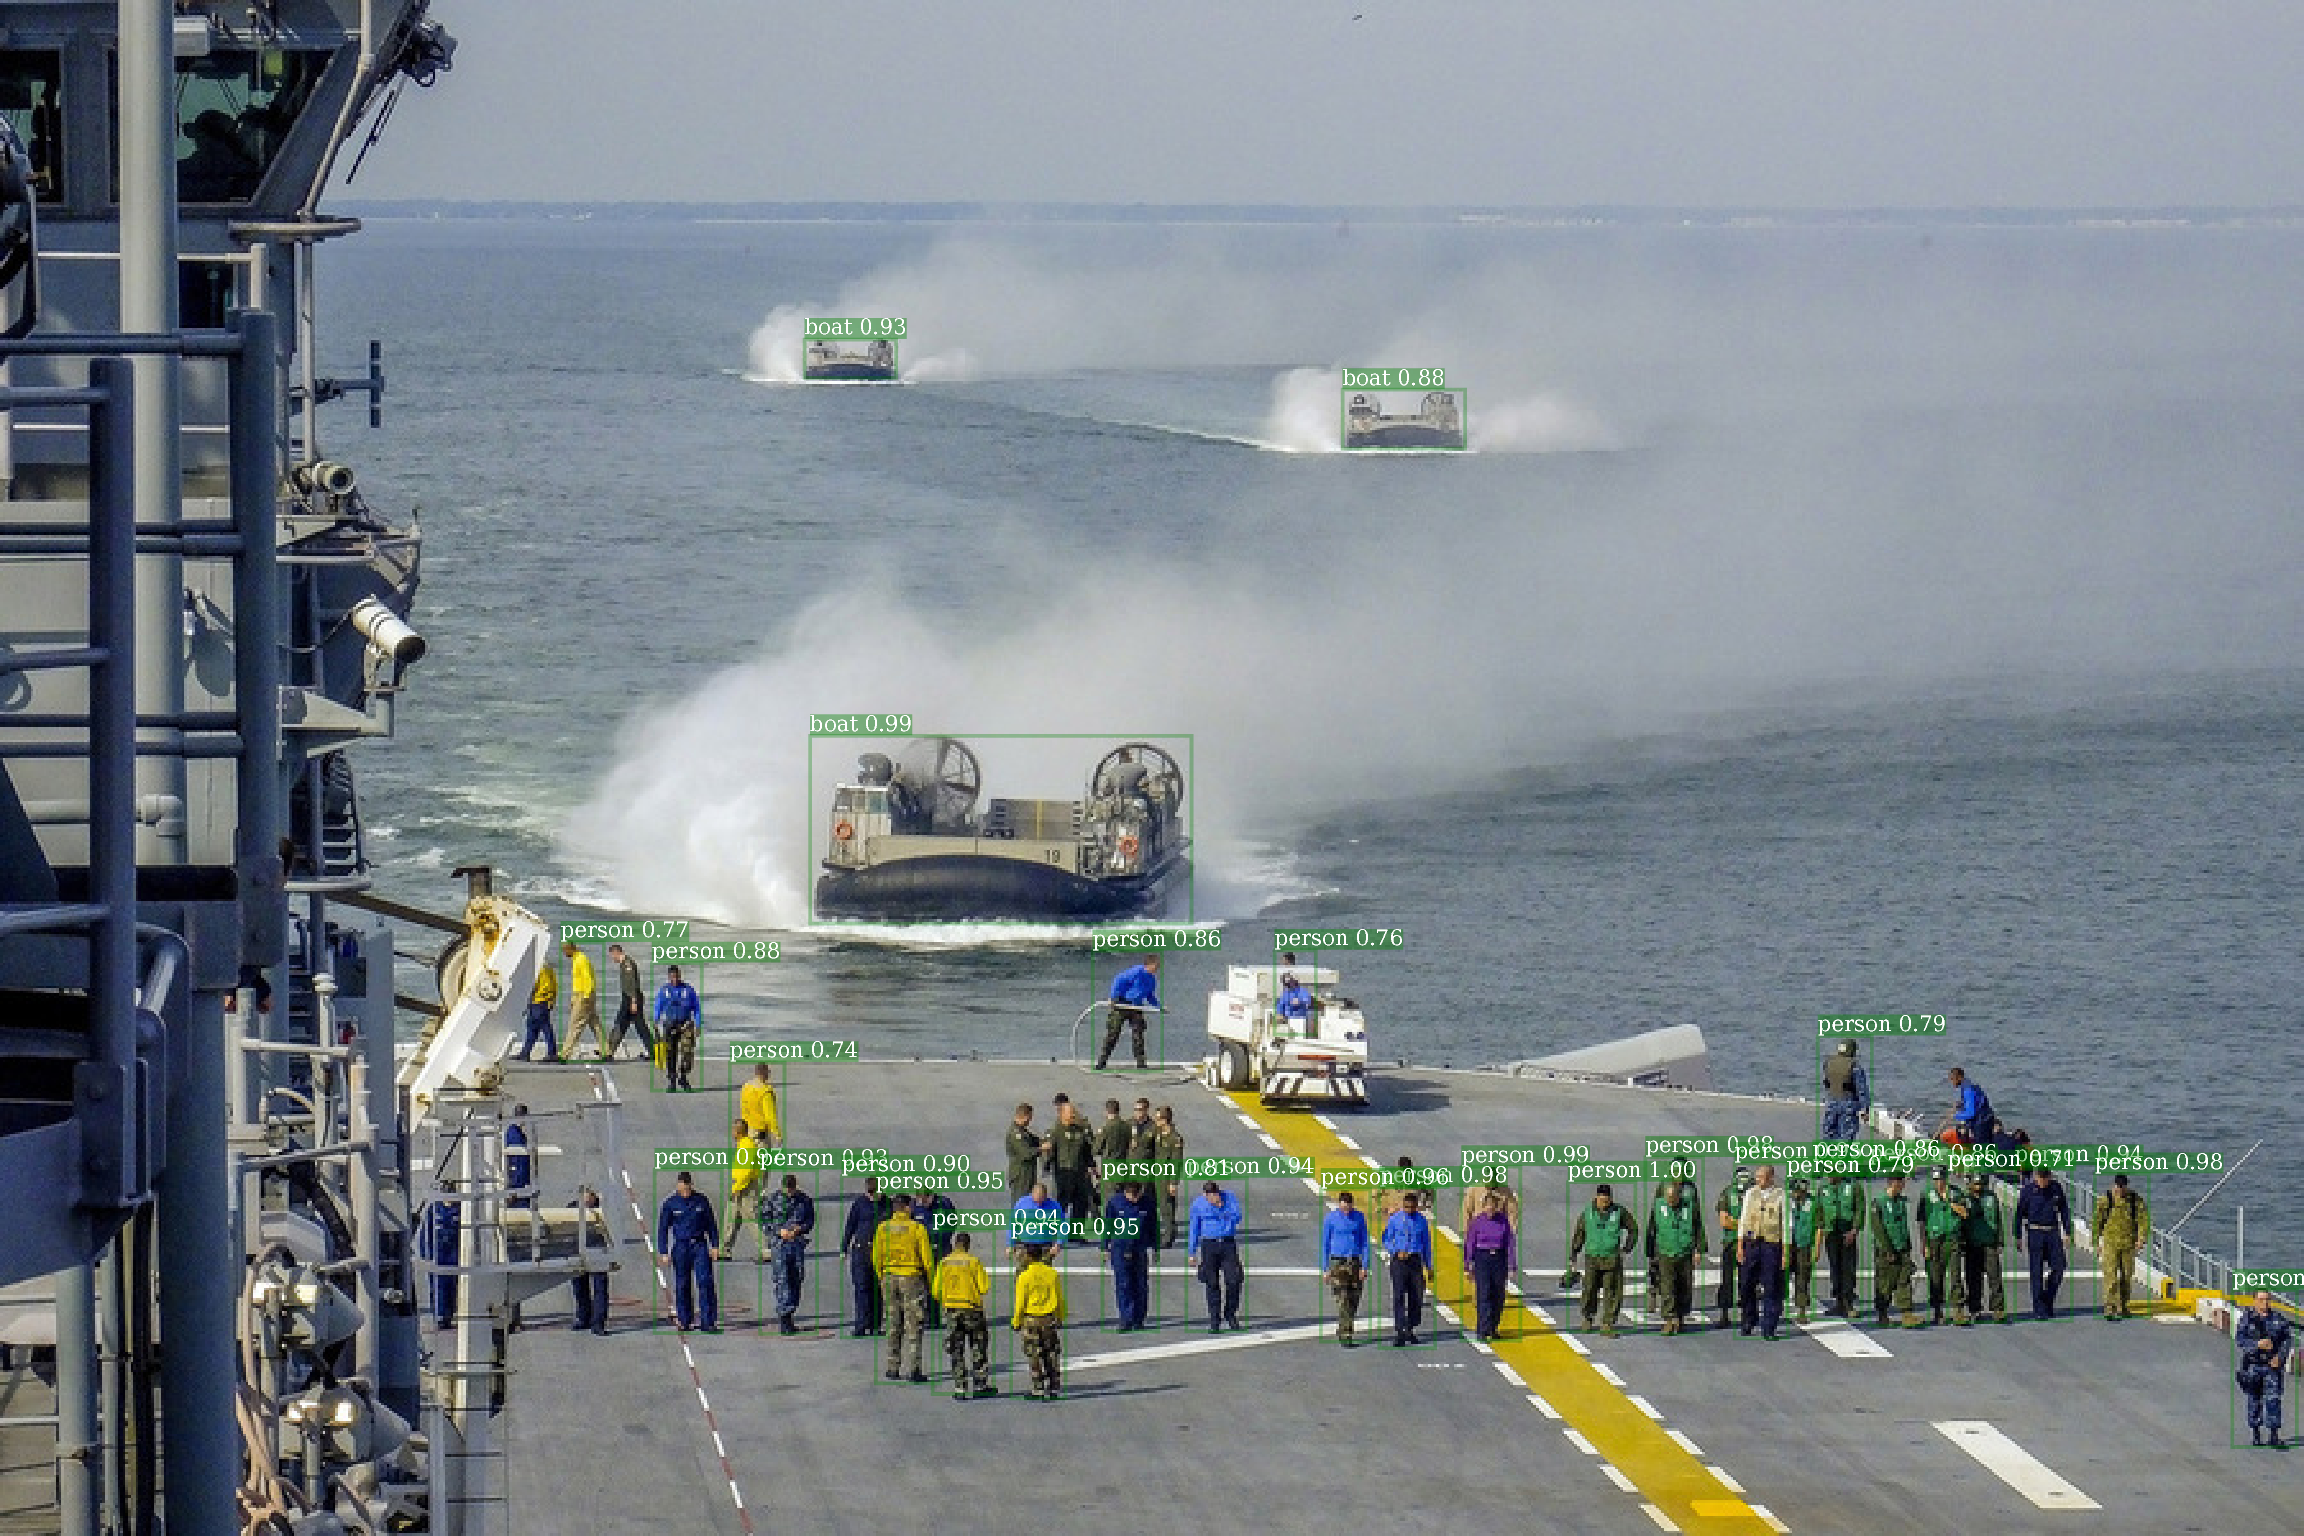

In [13]:
from wand.image import Image as WImage
WImage(filename='/workspace/faster-rcnn-visualization-3/15673749081_767a7fa63a_k.jpg.pdf', resolution=512)

###  GPU Profiling 

#### Profiling with `nvprof`

In [14]:
%cd /detectron/
!nvprof python3 tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml \
    --output-dir /workspace/faster-rcnn-visualization-3 \
    --image-ext jpg \
    --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml.01_38_50.sNxI7sX7/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl \
        demo/15673749081_767a7fa63a_k.jpg

/detectron
==1038== NVPROF is profiling process 1038, command: python3 tools/infer_simple.py --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml --output-dir /workspace/faster-rcnn-visualization-3 --image-ext jpg --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rc
E0306 22:31:45.461580  1038 init_intrinsics_check.cc:59] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:31:45.461611  1038 init_intrinsics_check.cc:59] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:31:45.461618  1038 init_intrinsics_check.cc:59] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
WARNING cnn.py:  40: [====DEPRECATE WARNING====]: you are creating an object 

Visualizing profiles in Nvidia Visual Profiler

In [15]:
%cd /detectron/
!nvprof -f -o /workspace/out.nvvp python3 tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml \
    --output-dir /workspace/faster-rcnn-visualization-3 \
    --image-ext jpg \
    --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml.01_38_50.sNxI7sX7/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl \
        demo/15673749081_767a7fa63a_k.jpg

/detectron
==1070== NVPROF is profiling process 1070, command: python3 tools/infer_simple.py --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml --output-dir /workspace/faster-rcnn-visualization-3 --image-ext jpg --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rc
E0306 22:32:34.277786  1070 init_intrinsics_check.cc:59] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:32:34.277819  1070 init_intrinsics_check.cc:59] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:32:34.277827  1070 init_intrinsics_check.cc:59] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
WARNING cnn.py:  40: [====DEPRECATE WARNING====]: you are creating an object 

####  cudaMalloc is causing the space in the Compute of our application
![](screenshots/hw5-10.png)

####  NVTX ranges

In [16]:
%%writefile tools/infer_simple.py
#!/usr/bin/env python2

# Copyright (c) 2017-present, Facebook, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
##############################################################################

"""Perform inference on a single image or all images with a certain extension
(e.g., .jpg) in a folder.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import glob
import logging
import os
import sys
import time

from caffe2.python import workspace

from core.config import assert_and_infer_cfg
from core.config import cfg
from core.config import merge_cfg_from_file
from utils.timer import Timer
import core.test_engine as infer_engine
import datasets.dummy_datasets as dummy_datasets
import utils.c2 as c2_utils
import utils.logging
import utils.vis as vis_utils

c2_utils.import_detectron_ops()
# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)


def parse_args():
    parser = argparse.ArgumentParser(description='End-to-end inference')
    parser.add_argument(
        '--cfg',
        dest='cfg',
        help='cfg model file (/path/to/model_config.yaml)',
        default=None,
        type=str
    )
    parser.add_argument(
        '--wts',
        dest='weights',
        help='weights model file (/path/to/model_weights.pkl)',
        default=None,
        type=str
    )
    parser.add_argument(
        '--output-dir',
        dest='output_dir',
        help='directory for visualization pdfs (default: /tmp/infer_simple)',
        default='/tmp/infer_simple',
        type=str
    )
    parser.add_argument(
        '--image-ext',
        dest='image_ext',
        help='image file name extension (default: jpg)',
        default='jpg',
        type=str
    )
    parser.add_argument(
        'im_or_folder', help='image or folder of images', default=None
    )
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()


def main(args):
    logger = logging.getLogger(__name__)
    merge_cfg_from_file(args.cfg)
    cfg.TEST.WEIGHTS = args.weights
    cfg.NUM_GPUS = 1
    assert_and_infer_cfg()
    model = infer_engine.initialize_model_from_cfg()
    dummy_coco_dataset = dummy_datasets.get_coco_dataset()

    if os.path.isdir(args.im_or_folder):
        im_list = glob.iglob(args.im_or_folder + '/*.' + args.image_ext)
    else:
        im_list = [args.im_or_folder]

    for i, im_name in enumerate(im_list):
        out_name = os.path.join(
            args.output_dir, '{}'.format(os.path.basename(im_name) + '.pdf')
        )
        logger.info('Processing {} -> {}'.format(im_name, out_name))
        im = cv2.imread(im_name)
        timers = defaultdict(Timer)
        t = time.time()
        with c2_utils.NamedCudaScope(0):
            cls_boxes, cls_segms, cls_keyps = infer_engine.im_detect_all(
                model, im, None, timers=timers
            )
        logger.info('Inference time: {:.3f}s'.format(time.time() - t))
        for k, v in timers.items():
            logger.info(' | {}: {:.3f}s'.format(k, v.average_time))
        if i == 0:
            logger.info(
                ' \ Note: inference on the first image will be slower than the '
                'rest (caches and auto-tuning need to warm up)'
            )

        vis_utils.vis_one_image(
            im[:, :, ::-1],  # BGR -> RGB for visualization
            im_name,
            args.output_dir,
            cls_boxes,
            cls_segms,
            cls_keyps,
            dataset=dummy_coco_dataset,
            box_alpha=0.3,
            show_class=True,
            thresh=0.7,
            kp_thresh=2
        )


if __name__ == '__main__':
    workspace.GlobalInit(['caffe2', '--caffe2_log_level=0', '--caffe2_use_nvtx'])
    utils.logging.setup_logging(__name__)
    args = parse_args()
    main(args)


Overwriting tools/infer_simple.py


#####  Run the inference again

In [18]:
%cd /detectron/
!nvprof -f -o out.nvvp python3 tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml \
    --output-dir /workspace/faster-rcnn-visualization-3 \
    --image-ext jpg \
    --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml.01_38_50.sNxI7sX7/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl \
        demo/15673749081_767a7fa63a_k.jpg

/detectron
==1117== NVPROF is profiling process 1117, command: python3 tools/infer_simple.py --cfg configs/12_2017_baselines/e2e_faster_rcnn_R-101-FPN_1x.yaml --output-dir /workspace/faster-rcnn-visualization-3 --image-ext jpg --wts https://s3-us-west-2.amazonaws.com/detectron/35857890/12_2017_baselines/e2e_faster_rc
E0306 22:33:47.103062  1117 init_intrinsics_check.cc:59] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:33:47.103096  1117 init_intrinsics_check.cc:59] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
E0306 22:33:47.103101  1117 init_intrinsics_check.cc:59] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
WARNING cnn.py:  40: [====DEPRECATE WARNING====]: you are creating an object 

![](screenshots/hw5-11.png)